In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pydub import AudioSegment
import time

import pyaudio
import wave

from pyannote.core import Annotation, Segment
from pyannote.audio.pipelines import VoiceActivityDetection

In [2]:
silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation")
HYPER_PARAMETERS = {
  # onset/offset activation thresholds
  "onset": 0.5, "offset": 0.5,
  # remove speech regions shorter than that many seconds.
  "min_duration_on": 0.0,
  # fill non-speech regions shorter than that many seconds.
  "min_duration_off": 0.0
}
silence_detection_pipeline.instantiate(HYPER_PARAMETERS)

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/318 [00:00<?, ?B/s]

In [8]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 30
WAVE_OUTPUT_FILENAME = "Data/voice.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

TIME_TO_CUT = 1.5

t0 = time.time()
t0_start_talk = time.time()
silence_th = 0
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    if time.time()-t0 > 1:
        
        print("Hola", time.time()-t0_start_talk)
        
        wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()
        
        vad = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
        
        x = vad.get_timeline().segments_set_
        
        if len(x) > silence_th:
            last_time_talk = np.max([x_elt.end for x_elt in list(x)])
            if time.time()-(last_time_talk+t0_start_talk) > TIME_TO_CUT:
                break
            else:
                # silence_th += len(x)-1
                silence_th = len(x)
        
        t0 = time.time()

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
Hola 1.0012104511260986
Hola 2.050791025161743
Hola 3.236137628555298
Hola 4.325390338897705
Hola 5.5145583152771
Hola 6.731540679931641
Hola 8.016660213470459
Hola 9.345710754394531
Hola 10.745115041732788
Hola 12.225535154342651
Hola 13.748117923736572
Hola 15.303513050079346
Hola 16.92009472846985
Hola 18.60438847541809
Hola 20.3416006565094
Hola 22.113121271133423
Hola 23.91761350631714
Hola 25.809568643569946
* done recording


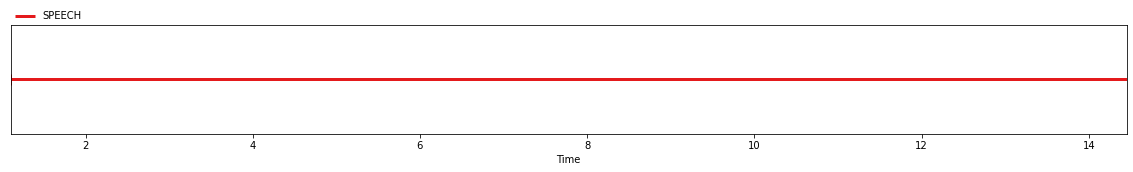

In [9]:
VAD = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
VAD